In [1]:
import meshio
import pygalmesh
import numpy as np
import copy
from mshr import *
from dolfin import *
from collections import Counter
import matplotlib.pyplot as plt
import os
import json
import shutil
import scipy.optimize as opt
from EnergyMinimization import *

# Initialisation

User settings: What are the continuum parameters we want? 

In [2]:
# Target mesh size:
target_a = 0.2
# continuum bending modulus:
kc=1
# continuum shear modulus:
mu=1

# Total Number of inflations
NumInflations=250
# the value of g0 (this changes over time)
g0 = 1

#logging interval
LogInterval=50000

Right, lets define the bond type and parameters for each bond. In 2D, we know that the elastic modulii are proportional to the microscopic spring constant. We also know that the continuum and microscopic momdulii are related by a lattice space: $\mu = O(1) k$, $k_c = k_d a$. Since I dont know any better, for know I will just set k to mu.

In [3]:
kd=kc/target_a
k = mu
theta0=np.pi

Set up the experiment

In [4]:
# root folder for data
DataFolder=os.getcwd()+'/Data/'
# Folder for the run data
RunFolder="Sweep/"
# Name of the run
RunName="Disk"
# Name of the current file
ScriptName="EnergyMinimizationScript.ipynb"

path = DataFolder+RunFolder
# make the folder 
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
    
# try and clear out the folder if there was a previous run in it
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
        
        
#Dump all the parameters to a file in the run folder        
f=open(DataFolder+RunFolder+"Parameters.log","w+")
datadict= { 
        "a":target_a,
        "kc":kc, 
        "mu":mu,
        "go":g0,
}
json.dump(datadict,f)
f.close()

# and for good measure, dump a copy of this code into the data file too
shutil.copyfile(ScriptName,DataFolder+RunFolder+ScriptName)

Creation of the directory /home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Sweep/ failed


'/home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Sweep/EnergyMinimizationScript.ipynb'

Make the mesh, write it out to the folder

In [5]:
InputMesh, OutputMesh, interiorbonds,edgebonds,angletriples = MakeDolfinMesh(target_a,40)
InputMesh.write(DataFolder+RunFolder+RunName+"InputMesh.vtk")

Check out the Mesh. One of the lessons learnt is that you shouldnt have much of a spread in the intial edge lengths

0.15691819145568991

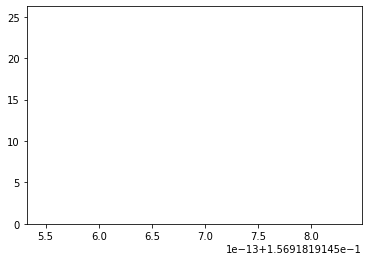

In [6]:
edgelengths= MakeBondHist(InputMesh.points,edgebonds)
np.mean(edgelengths)

# Energy Minimization

In [7]:
# def dist(P):
#     return np.sqrt((P[:,0]-P[:,0][:,np.newaxis])**2 +
#                    (P[:,1]-P[:,1][:,np.newaxis])**2)

In [ ]:
# def vNeoHookean(r_ij,khook,r0_ij):
#     kneo_ij = (r0_ij**2)*khook/3  
#     # the diagonal is irrelevant, just fill it with 1's
#     np.fill_diagonal(r_ij,1)
#     np.fill_diagonal(r0_ij,1)
#     lam_ij=r_ij/r0_ij
#     V_ij=(kneo_ij/2)*((2/lam_ij) + lam_ij**2)
#     return V_ij
    

In [ ]:
# def NeoHookean(r,khook,r0):
#     kneo = (r0**2)*khook/3
#     lam=r/r0
#     V=(kneo/2)*((2/lam) + lam**2)
#     return V

In [ ]:
# # The argument P is a vector (flattened matrix), needed for scipy
# def energy(P): 
#     # We convert it to a matrix here.
#     P_ij = P.reshape((-1, 2))
#     # We compute the distance matrix.
#     r_ij = dist(P_ij)
#     # NeoHookean Spring bond energies
#     # 0.5 to account for double counting
#     SpringEnergy = (0.5*A*vNeoHookean(r_ij,1,r0_ij)).sum()   
#     #bond bending energy
#     BendingEnergy = vBending(P_ij,theta0).sum()
#     return SpringEnergy+BendingEnergy

In [8]:
def mycallback(xi):
    counter=len(history)
    history.append(xi)
    print(counter)
    tempP = xi.reshape((-1, 2))
    #output for visualisation
    OutputMesh.points[:,0:2] = tempP           
    OutputMesh.write(DataFolder+RunFolder+RunName+str(counter)+"Output.vtk",binary=True)

In [9]:
# initial points
P0_ij =InputMesh.points[:,0:2] 
N = len(P0_ij)
# the "prestress" matrix, referring to scale factors for the rest lengths
g0= np.ones((N,N),)
for bond in edgebonds:
    g0[bond[0],bond[1]]=10
    g0[bond[1],bond[0]]=10
    
# the preferred rest lengths of all the springs
r0_ij = g0*dist(P0_ij)
# the connectivity matrix
A = np.zeros( (len(P0_ij),len(P0_ij)) )
for bond in edgebonds+interiorbonds:
    A[bond[0],bond[1]]=1
    A[bond[1],bond[0]]=1

In [12]:
# the energy minisation:
history = []
P1 = opt.minimize(energy, P0_ij.ravel(),args=(A,r0_ij,angletriples,k,kd,theta0),callback=mycallback,method='BFGS', options={'gtol': 1e-6, 'disp': True}).x.reshape((-1, 2))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
#output for visualisation
OutputMesh.points[:,0:2] = P1            
OutputMesh.write(DataFolder+RunFolder+RunName+"Output.vtk",binary=True)